# Exploration Phase - Linear Models Only - Fast Proof of Concept (POC)

**GOAL: Create a Classification Model that can predict whether or not a person would buy an item we offered them (via push notification) based on behavioral and personal features of that user (user id, ordered before, etc), features of that specific order (date, etc) and features of the items themselves (popularity, price, avg days to buy, etc)**

We must notice that sending too many notifications would have a negative impact on user experience.


## Imports

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_curve, auc

In [3]:
path = r'/home/carleondel/data-zrive-ds/box_builder_dataset/feature_frame.csv'
df = pd.read_csv(path)

## Data

This dataset contains 26 attributes based on the orders users make. Whenever an order is made, we take a picture of the whole inventory. The 'outcome' feature refers to the presence of each inventory's item in the order (0 for no presence, 1 for presence)

Content


- item id (variant_id)
- product type
- order id
- user id
- created at 
- order date
- sequence of the item within the order
- outcome: 0 for item not ordered, 1 for item ordered
- ordered before (0,1)
- abandoned before (0,1)
- active snoozed (0,1)
- set as regular (0,1)
- normalised price
- discount percentage
- vendor
- global popularity
- count adults
- count children
- count babies
- count pets
- people except babies
- days since last purchase of that item
- avg days to buy that item
- std days to buy that item
- days since last purchase of that product type
- avg days to buy that product type
- std days to buy that product type

### EDA & Visualizations

In [4]:
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2880549 entries, 0 to 2880548
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      fl

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
variant_id,2880549.0,3.401250e+13,2.786246e+11,3.361529e+13,3.380354e+13,3.397325e+13,3.428495e+13,3.454300e+13
order_id,2880549.0,2.978388e+12,2.446292e+11,2.807986e+12,2.875152e+12,2.902856e+12,2.922034e+12,3.643302e+12
user_id,2880549.0,3.750025e+12,1.775710e+11,3.046041e+12,3.745901e+12,3.812775e+12,3.874925e+12,5.029635e+12
user_order_seq,2880549.0,3.289342e+00,2.140176e+00,2.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,2.100000e+01
outcome,2880549.0,1.153669e-02,1.067876e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
ordered_before,2880549.0,2.113868e-02,1.438466e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
abandoned_before,2880549.0,6.092589e-04,2.467565e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
active_snoozed,2880549.0,2.290188e-03,4.780109e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
set_as_regular,2880549.0,3.629864e-03,6.013891e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
normalised_price,2880549.0,1.272808e-01,1.268378e-01,1.599349e-02,5.394416e-02,8.105178e-02,1.352670e-01,1.000000e+00


<Axes: xlabel='outcome', ylabel='count'>

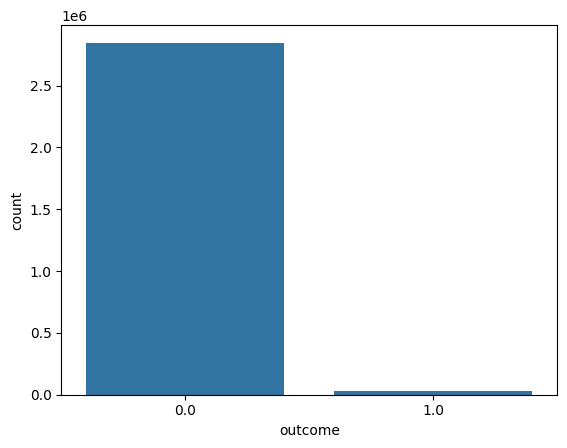

In [7]:
sns.countplot(x='outcome', data=df)

We are considering all the items on inventory for each order. In the column 'outcome' we have 1 if the item was bought and 0 if it was not. Therefore, it is normal that most of our order_ids have an 'outcome' of 0.

In [8]:
df['outcome'].value_counts()

outcome
0.0    2847317
1.0      33232
Name: count, dtype: int64

### Filtering 
We are asked to consider only those orders with 5 items or more to build the dataset to work with.

In [9]:
# We group by 'order_id' and sum the outcomes
df_grouped = orders_filtered = df.groupby('order_id')['outcome'].sum().reset_index()
df_grouped

,order_id,outcome
0,2807985930372,9.0
1,2808027644036,6.0
2,2808099078276,9.0
3,2808393957508,13.0
4,2808429314180,3.0
...,...,...
3441,3643254800516,9.0
3442,3643274788996,5.0
3443,3643283734660,21.0
3444,3643294515332,7.0


In [10]:
# We filter the orders by the outcome sum >= 5
filtered_orders = df_grouped[df_grouped['outcome'] >=5 ]['order_id']
filtered_orders

0       2807985930372
1       2808027644036
2       2808099078276
3       2808393957508
5       2808434524292
            ...      
3438    3643241300100
3441    3643254800516
3442    3643274788996
3443    3643283734660
3444    3643294515332
Name: order_id, Length: 2603, dtype: int64

In [11]:
# We filter the original df using the filtered order ids 
df_filtered = df[df['order_id'].isin(filtered_orders)]

In [12]:
print(f"We have kept {100*len(df_filtered) / len(df):.2f} % of the original dataset")

We have kept 75.12 % of the original dataset


In [13]:
# Quick check to make sure we filtered properly
sum(df_filtered.groupby('order_id')['outcome'].sum() <5)

0

### Dividing our columns

In [14]:
df_filtered.columns

Index(['variant_id', 'product_type', 'order_id', 'user_id', 'created_at',
       'order_date', 'user_order_seq', 'outcome', 'ordered_before',
       'abandoned_before', 'active_snoozed', 'set_as_regular',
       'normalised_price', 'discount_pct', 'vendor', 'global_popularity',
       'count_adults', 'count_children', 'count_babies', 'count_pets',
       'people_ex_baby', 'days_since_purchase_variant_id',
       'avg_days_to_buy_variant_id', 'std_days_to_buy_variant_id',
       'days_since_purchase_product_type', 'avg_days_to_buy_product_type',
       'std_days_to_buy_product_type'],
      dtype='object')

In [15]:
categorical_cols = ['variant_id', 'product_type', 'order_id', 'user_id', 'vendor']
binary_cols = ['outcome', 'ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular',]
numerical_cols = [cols for cols in df_filtered.columns if cols not in (categorical_cols+binary_cols)]

----
----

# Machine Learning

## Feature engineering

- Decide how to encode the categorical variables. By now we are going to remove all the categorical variables in order to simplify the problem. 

- Extract features from the dates columns. We are only going to keep the 'created_at' column and extract the year, month, day and hour from it (the column 'order_date' contains redundant information)


In [16]:
df_filtered['created_at']

0          2020-10-05 16:46:19
1          2020-10-05 17:59:51
2          2020-10-05 20:08:53
3          2020-10-06 08:57:59
5          2020-10-06 10:50:23
                  ...         
2880541    2021-03-03 12:56:04
2880544    2021-03-03 13:19:28
2880545    2021-03-03 13:57:35
2880546    2021-03-03 14:14:24
2880547    2021-03-03 14:30:30
Name: created_at, Length: 2163953, dtype: object

In [17]:
df_filtered['created_at'] = pd.to_datetime(df_filtered['created_at'])

/tmp/ipykernel_2827/3071389778.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['created_at'] = pd.to_datetime(df_filtered['created_at'])


In [18]:
# We extract features from our date info
df_filtered['year'] = df_filtered['created_at'].dt.year
df_filtered['month'] = df_filtered['created_at'].dt.month
df_filtered['day'] = df_filtered['created_at'].dt.day
df_filtered['hour'] = df_filtered['created_at'].dt.hour

/tmp/ipykernel_2827/1622433905.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['year'] = df_filtered['created_at'].dt.year
/tmp/ipykernel_2827/1622433905.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['month'] = df_filtered['created_at'].dt.month
/tmp/ipykernel_2827/1622433905.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [19]:
categorical_cols

['variant_id', 'product_type', 'order_id', 'user_id', 'vendor']

In [20]:
# cols i'm not going to use this time
unwanted = ['order_date'] + categorical_cols

In [21]:
# We drop those columns 
df_filtered = df_filtered.drop(columns=unwanted)

In [22]:
df_filtered.head()

,created_at,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,global_popularity,...,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,year,month,day,hour
0,2020-10-05 16:46:19,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,0.000000,...,33.0,42.0,31.134053,30.0,30.0,24.27618,2020,10,5,16
1,2020-10-05 17:59:51,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,0.000000,...,33.0,42.0,31.134053,30.0,30.0,24.27618,2020,10,5,17
2,2020-10-05 20:08:53,4,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,0.000000,...,33.0,42.0,31.134053,30.0,30.0,24.27618,2020,10,5,20
3,2020-10-06 08:57:59,2,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,0.038462,...,33.0,42.0,31.134053,30.0,30.0,24.27618,2020,10,6,8
5,2020-10-06 10:50:23,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,0.038462,...,33.0,42.0,31.134053,30.0,30.0,24.27618,2020,10,6,10


## Train | Validation | Test Split and Scaling

In order to avoid data leakage, since we are working with temporal data, we need to sort our dataset by date and divide it sequentially. We are going to take a 70-15-15 split for the dataset.


In [23]:
# We order our dataset by date
df_filtered = df_filtered.sort_values(by= 'created_at', ascending= True)

# We drop the 'created_at' column 
df_filtered = df_filtered.drop(columns= 'created_at')

In [24]:
df_filtered

,user_order_seq,outcome,ordered_before,abandoned_before,active_snoozed,set_as_regular,normalised_price,discount_pct,global_popularity,count_adults,...,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type,year,month,day,hour
0,3,0.0,0.0,0.0,0.0,0.0,0.081052,0.053512,0.000000,2.0,...,33.0,42.0,31.134053,30.0,30.0,24.276180,2020,10,5,16
481583,3,0.0,0.0,0.0,0.0,0.0,0.089184,0.151976,0.111111,2.0,...,33.0,30.0,30.234265,30.0,27.0,23.827826,2020,10,5,16
2398555,3,0.0,0.0,0.0,0.0,0.0,0.043101,1.006289,0.037037,2.0,...,33.0,41.5,28.238356,30.0,34.0,27.826713,2020,10,5,16
478137,3,0.0,0.0,0.0,0.0,0.0,0.026837,1.020202,0.000000,2.0,...,33.0,54.0,35.319072,30.0,37.0,30.506129,2020,10,5,16
2402001,3,0.0,0.0,0.0,0.0,0.0,0.129845,0.041754,0.000000,2.0,...,33.0,55.0,34.085746,30.0,37.0,27.032264,2020,10,5,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1313555,2,0.0,0.0,0.0,0.0,0.0,0.032258,0.260504,0.008571,2.0,...,33.0,34.0,28.556854,30.0,34.0,27.826713,2021,3,3,14
746573,2,0.0,0.0,0.0,0.0,0.0,0.121713,0.066815,0.013571,2.0,...,33.0,28.0,21.694590,36.0,27.0,23.827826,2021,3,3,14
1563628,2,0.0,0.0,0.0,0.0,0.0,0.121713,0.069042,0.011429,2.0,...,33.0,21.0,10.662606,30.0,27.0,23.634873,2021,3,3,14
1926032,2,0.0,0.0,0.0,0.0,0.0,0.024126,0.112360,0.010000,2.0,...,33.0,38.0,24.908885,30.0,31.0,25.535369,2021,3,3,14


In [25]:
# We define the size of each dataset
train_size = int(0.7 * len(df_filtered))
val_size = int(0.15 * len(df_filtered))

# We divide the df after being sorted
df_train = df_filtered.iloc[:train_size]
df_val = df_filtered.iloc[train_size:train_size + val_size]
df_test = df_filtered.iloc[train_size + val_size:]

# We verify there is no data in common (Assertion error if it fails)
assert df_train.index.intersection(df_val.index).empty
assert df_val.index.intersection(df_test.index).empty
assert df_train.index.intersection(df_test.index).empty

In [26]:
X_train = df_train.drop('outcome', axis=1)
y_train = df_train['outcome']

X_val = df_val.drop('outcome', axis=1)
y_val = df_val['outcome']

X_test = df_test.drop('outcome', axis=1)
y_test = df_test['outcome']

In [28]:
# Initialize the scaler
scaler = StandardScaler()

Now we normalize the X train, test and validation data. We only fit to the training data in order to avoid data leakage (statistics coming from the val/test data).

In [29]:
scaled_X_train = scaler.fit_transform(X_train)

scaled_X_val = scaler.transform(X_val)

scaled_X_test = scaler.transform(X_test)

## Logistic Regression Model

In [31]:
# Initialize our model
model = LogisticRegression()

# Train our model
model.fit(scaled_X_train, y_train)

LogisticRegression()

In [32]:
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

----


## Model Performance Evaluation
- Confusion Matrix
- Accuracy, Precision, etc

Now we use our validation dataset to improve the selection of hyperparameters
(Not yet)

In [34]:
y_pred = model.predict(scaled_X_val)

In [35]:
confusion_matrix(y_val, y_pred)

array([[319850,    348],
       [  4161,    233]])

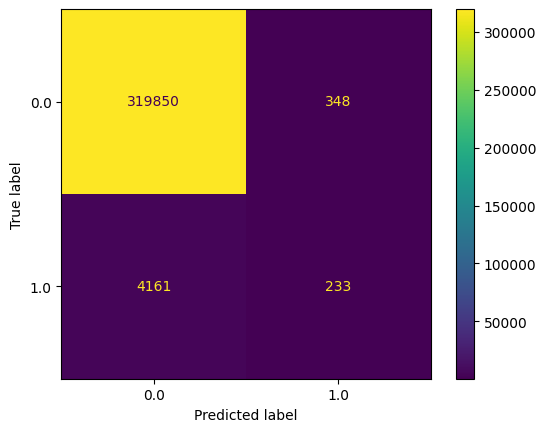

In [37]:
ConfusionMatrixDisplay.from_estimator(model,scaled_X_val,y_val)

In [38]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99    320198
         1.0       0.40      0.05      0.09      4394

    accuracy                           0.99    324592
   macro avg       0.69      0.53      0.54    324592
weighted avg       0.98      0.99      0.98    324592



We have a good performance on the negative instances, but a really poor performance for our positive cases. It can be explained by the existing inbalance of our classes in the dataset and also because we need to improve this model.

Out of all the predicted positives (orders predicted), only 40% are correct (precision) and out of all the true positives (true orders), we are only predicting 5% of them correctly (and predicting 95% as negatives) (recall).

### Performance Curves
- Precision-recall curve
- ROC curve

(Next steps) What are we comparing our model to? We can consider: choosing at random and choosing based on item popularity

In [40]:
# We calculate the probabilities of being positive for the validation test

y_val_proba = model.predict_proba(scaled_X_val)[:, 1]

In [43]:
# We calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

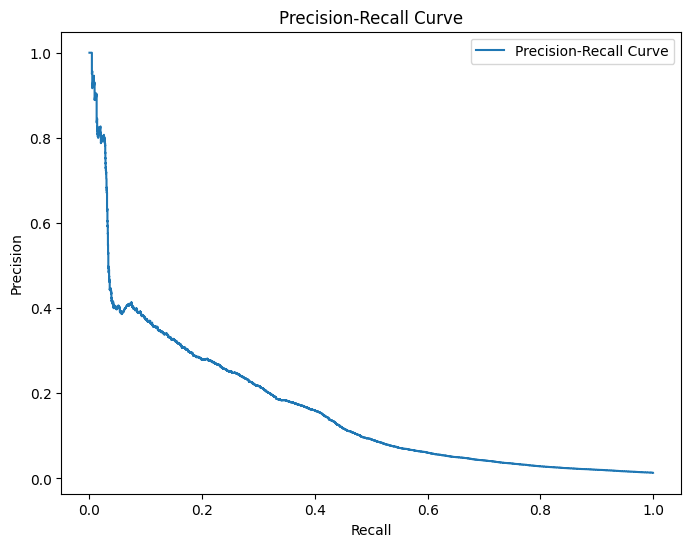

In [44]:
# We plot the precision-recall curve

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

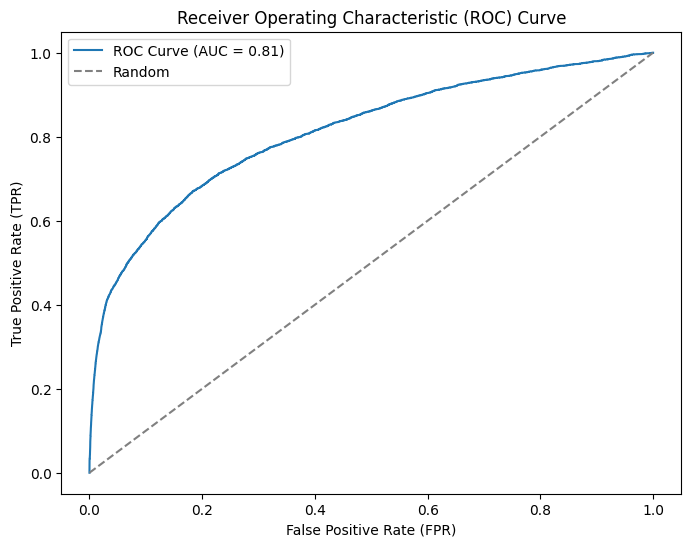

In [46]:
# ROC curve
fpr, tpr, thresholds =  roc_curve(y_val, y_val_proba)

# Calculate Area Under Curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

We have an AUC of 0.81, much better than guessing at random. But this curve is not really informative in our case since we have very unbalanced classes